### DeepLearning.ai course: "Long-Term Agentic Memory With LangGraph"

link: https://learn.deeplearning.ai/courses/long-term-agentic-memory-with-langgraph/lesson/a0k5a/baseline-email-assistant

#### Lesson 2: Baseline Email Assistant
This lesson builds an email assistant that:

Classifies incoming messages (respond, ignore, notify)
Drafts responses
Schedules meetings
We'll start with a simple implementation - one that uses hard-coded rules to handle emails.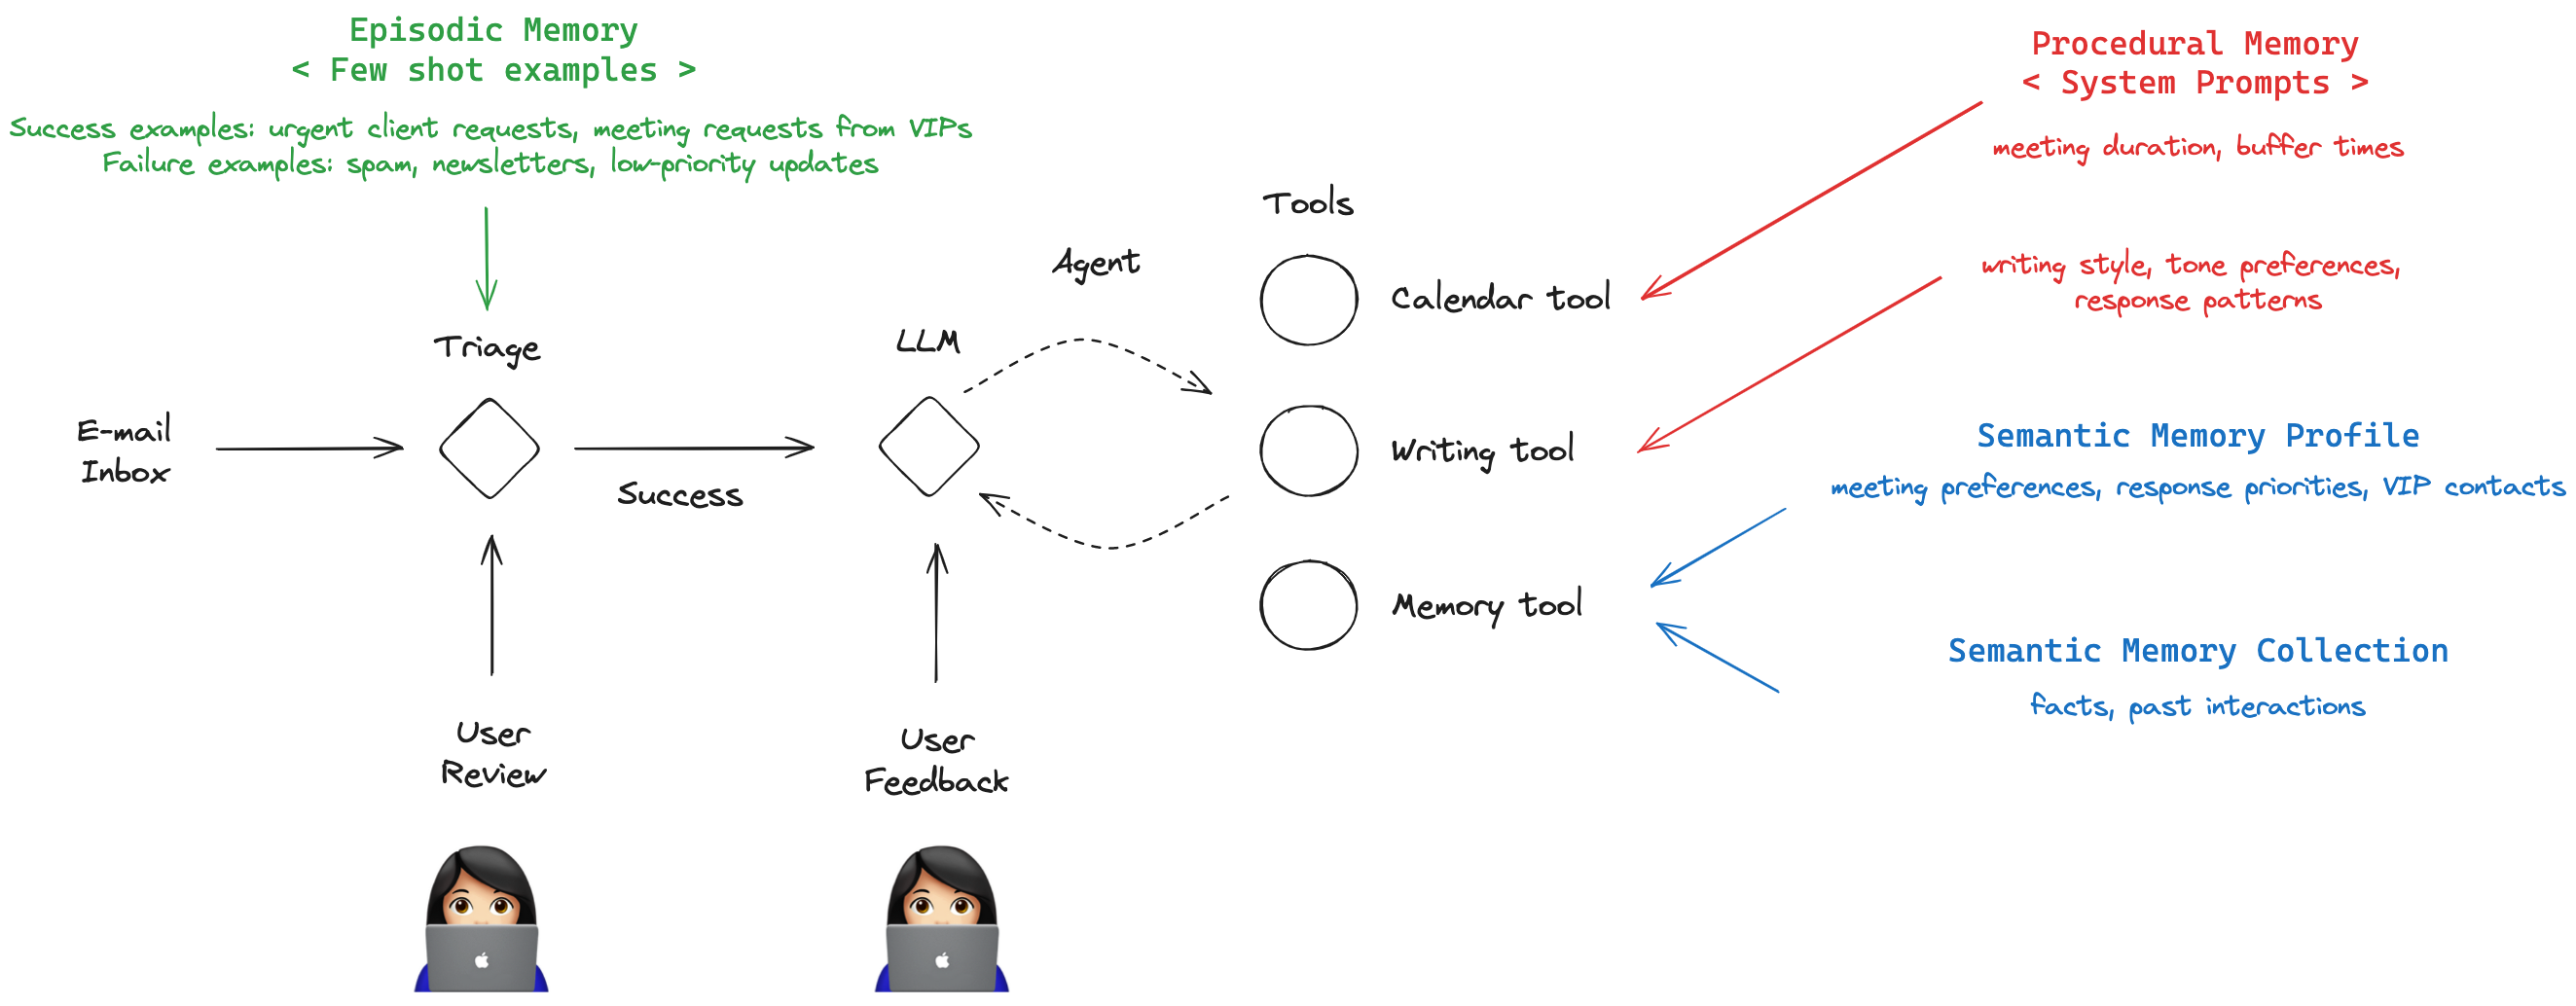!
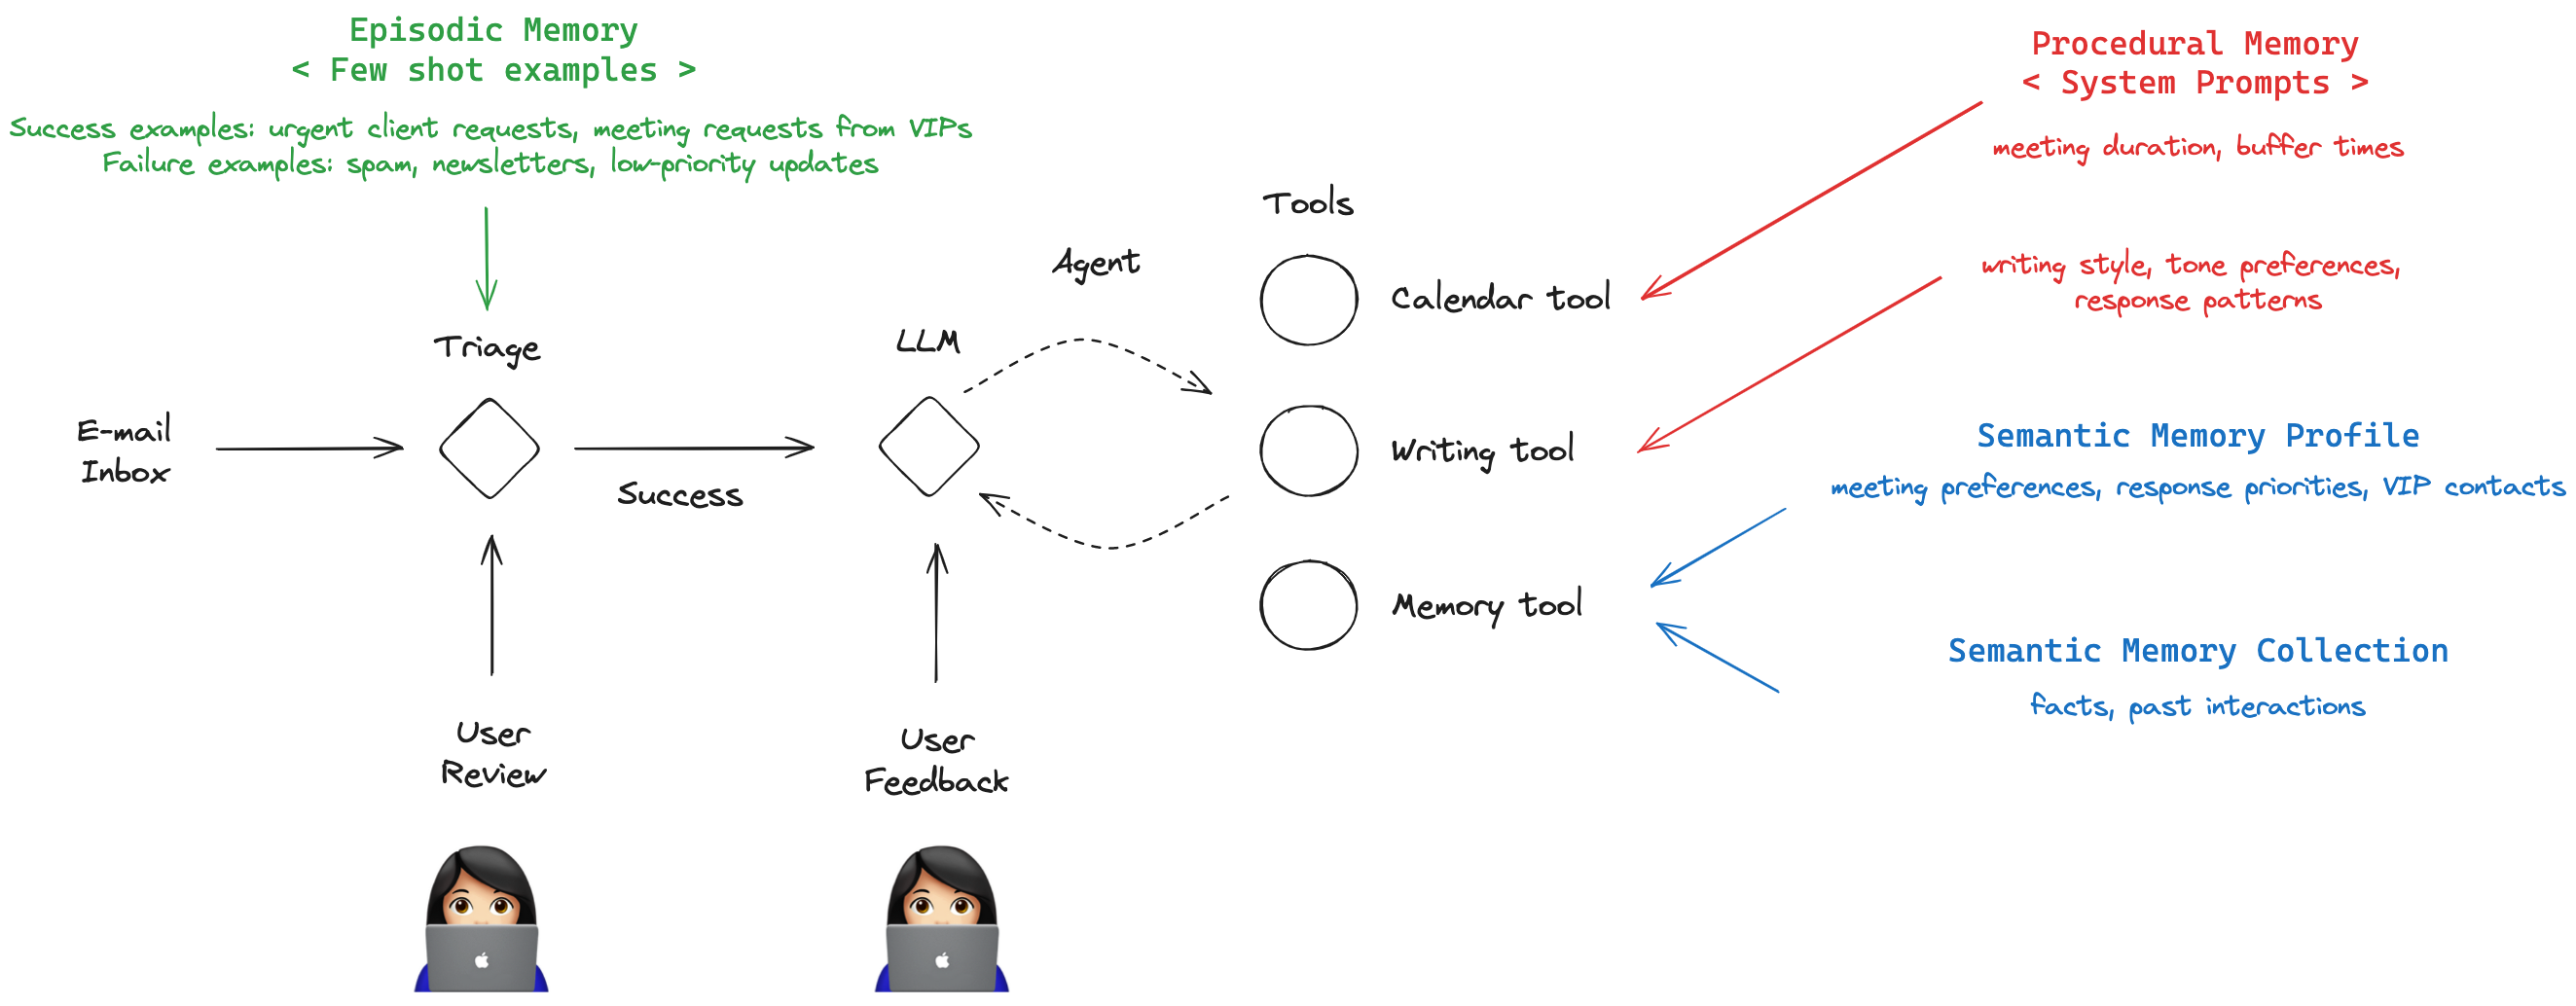
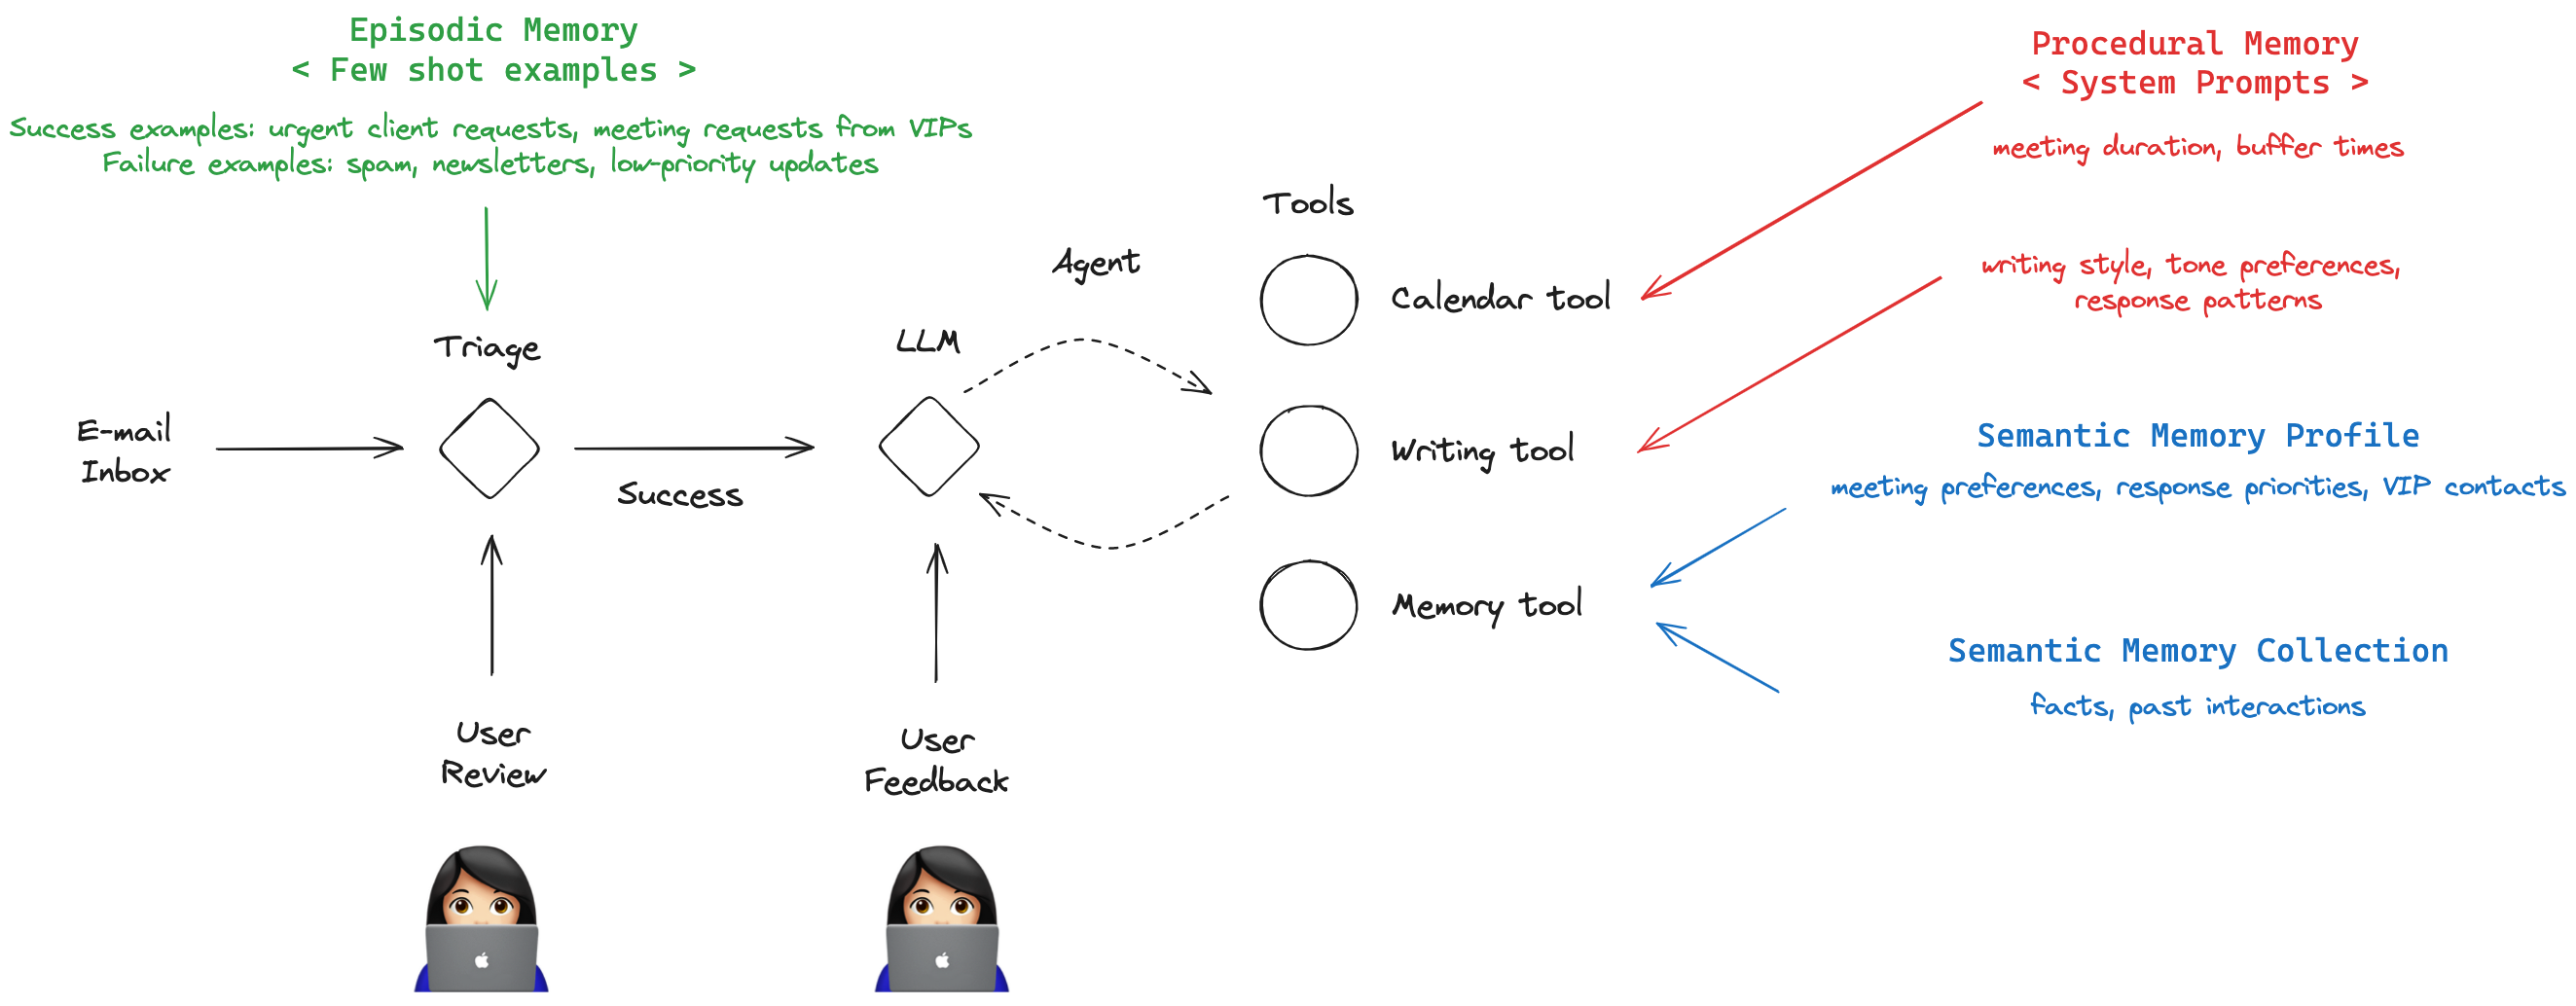
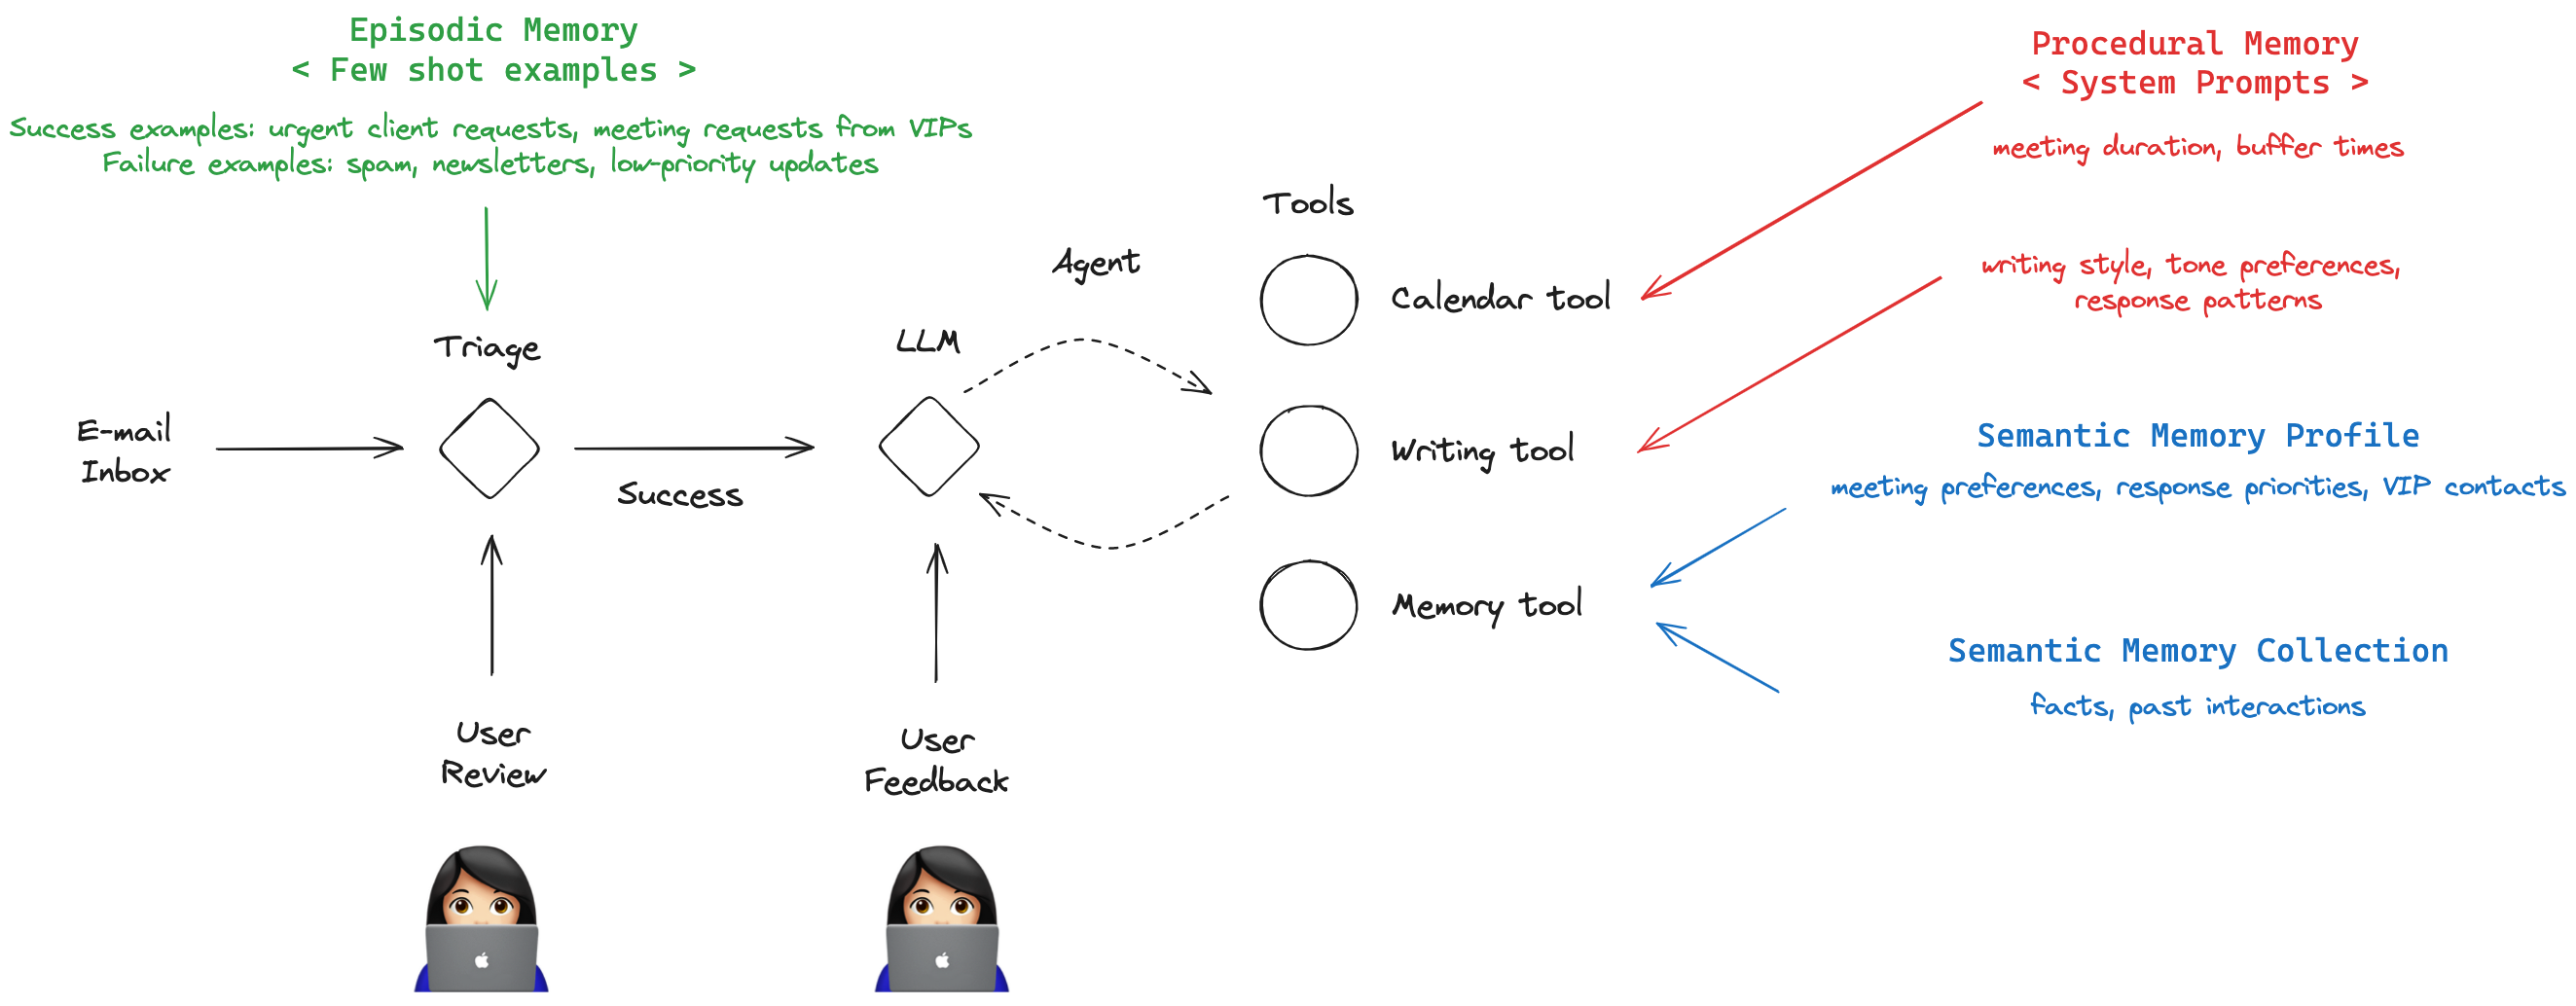

<div style="background-color:steelblue; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> , notebooks and other files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

## Imports

In [73]:
# Standard Library
import json
import re

# Third-party Libraries
import duckdb
import numpy as np
import pandas as pd

# LangChain and OpenAI Libraries
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

## Load API tokens for our 3rd party APIs

In [74]:
# Initialize OpenAI API Client with Bayer Token

# import token
with open('secrets/MyGenAI_key.txt', 'r') as file:
    dictionary = json.load(file)
    
int_bayer_url = "https://chat.int.bayer.com/api/v2"
    
token = dictionary['key']
client = OpenAI(api_key=token, base_url=int_bayer_url)

## Setup a Profile, Prompt and Example Email

In [75]:
profile = {
    "name": "Ignasi",
    "full_name": "Ignasi Montero Serra",
    "user_profile_background": "Data Scientist leading multiple AI projects",
}

In [76]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage Ignasi's tasks efficiently."
}

## Initialise the model w MygenAssist API


In [77]:
# Initialise the LLM model
llm = init_chat_model(
    model='gpt-4o-mini',
    temperature=0,
    api_key=token,
    base_url=int_bayer_url
)

### test API

In [78]:
# Define a simple test prompt
test_prompt = "Hello! Can you summarize the concept of machine learning in one sentence?"

# Try invoking the model
try:
    response = llm.invoke([{"role": "user", "content": test_prompt}])
    print("LLM Response:", response)
except Exception as e:
    print("Error:", e)


LLM Response: content='Machine learning is a subset of artificial intelligence that enables systems to learn from data, identify patterns, and make decisions with minimal human intervention.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 21, 'total_tokens': 49, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_ded0d14823', 'id': '0195c451-d070-7d47-9b89-9867946dd48b', 'finish_reason': 'stop', 'logprobs': None} id='run-3eac5f75-f6ab-4a36-9665-98b110ff1fbe-0' usage_metadata={'input_tokens': 21, 'output_tokens': 28, 'total_tokens': 49, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


## Define the first part of the agent - triage.

In [79]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [80]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [81]:
llm_router = llm.with_structured_output(Router)

#### Understanding llm.with_structured_output(Router)
This line modifies how the LLM outputs its response. Instead of returning free-text output, it structures the response according to a predefined format (Router in this case).

When you invoke llm_router, instead of returning free-form text, it ensures the output is a structured JSON-like object that matches Router.

#### What is Router?
Router is a Pydantic model that defines a structured response.
It expects the LLM to return:
1. reasoning → A string explaining the classification.
2. classification → A choice between "ignore", "respond", or "notify".

#### Why Is This Useful?
1. Ensures consistency → Always returns responses in the same format.
2. Easier parsing → You get a structured object instead of free-form text.
3. Prevents hallucinations → The model is guided to respond within a strict schema.
4. Better for automation → Since output is structured, it's easier to integrate into workflows.

## Dynamic prompting

This part of the code is formatting a system prompt using the .format() method in Python. It customizes the triage_system_prompt template by inserting specific values.

This code dynamically formats a prompt for an email triage assistant, replacing placeholders in triage_system_prompt with user and rule-specific details. This makes the LLM more context-aware and improves classification accuracy.

In [82]:
from utils.prompts_routing import triage_system_prompt, triage_user_prompt

In [83]:
# Triage prompt
triage_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}. 
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >
{examples}
</ Few shot examples >
"""


In [84]:
system_prompt = triage_system_prompt.format(
    full_name=profile["full_name"],
    name=profile["name"],
    examples=None,
    user_profile_background=profile["user_profile_background"],
    triage_no=prompt_instructions["triage_rules"]["ignore"],
    triage_notify=prompt_instructions["triage_rules"]["notify"],
    triage_email=prompt_instructions["triage_rules"]["respond"],
)

In [94]:
system_prompt

"\n< Role >\nYou are Ignasi Montero Serra's executive assistant. You are a top-notch executive assistant who cares about Ignasi performing as well as possible.\n</ Role >\n\n< Background >\nData Scientist leading multiple AI projects. \n</ Background >\n\n< Instructions >\n\nIgnasi gets lots of emails. Your job is to categorize each email into one of three categories:\n\n1. IGNORE - Emails that are not worth responding to or tracking\n2. NOTIFY - Important information that Ignasi should know about but doesn't require a response\n3. RESPOND - Emails that need a direct response from Ignasi\n\nClassify the below email into one of these categories.\n\n</ Instructions >\n\n< Rules >\nEmails that are not worth responding to:\nMarketing newsletters, spam emails, mass company announcements\n\nThere are also other things that Ignasi should know about, but don't require an email response. For these, you should notify Ignasi (using the `notify` response). Examples of this include:\nTeam member ou

In [ ]:
# Example incoming email
email = {
    "from": "Robert Smith <Rober.smith@company.com>",
    "to": "Ignasi Montero <Ignasi.montero@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Robert""",
}

In [85]:
triage_user_prompt = """
Please determine how to handle the below email thread:

From: {author}
To: {to}
Subject: {subject}
{email_thread}"""


In [95]:
user_prompt = triage_user_prompt.format(
    author=email["from"],
    to=email["to"],
    subject=email["subject"],
    email_thread=email["body"],
)

### Understanding llm_router.invoke([...])
This line invokes (i.e., calls) the llm_router model to process a conversation by providing structured inputs.

It sends a Message to the LLM: This method sends a structured list of messages to the model for processing.
The messages follow ChatML format (roles: system, user, assistant).

**What Does result Contain?**

Since llm_router is set to structured output, the model’s response will match the Router class:

In [96]:
result = llm_router.invoke(
    [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
)

In [97]:
result.reasoning

'This email is a direct question from a team member (Robert) regarding the API documentation, which requires clarification on whether certain endpoints are intentionally missing or if they need to be updated. Ignasi needs to respond to Robert to provide the necessary information.'

In [90]:
result.classification

'respond'

## Main agent, define tools

In [98]:
from langchain_core.tools import tool

In [99]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"


@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"


### Explanation of @tool

This snippet defines a custom tool in LangChain, which can be used by an agent to perform specific tasks. 
Imports LangChain’s @tool decorator, which registers a function as an AI tool.

1. Turns the function write_email into a LangChain tool.
2. This allows LLM agents to call the function when needed.

LangChain agents can use this function dynamically when solving tasks.
For example, if an LLM is managing emails, it might decide to call write_email() when needed.

### What’s Special About @tool?
1. Registers the function as a tool without extra boilerplate.
2. Automatically extracts function signature (so LLMs know how to call it).
3. Allows LLM-powered agents to decide when and how to use the tool, so LLMs can take actions instead of just responding with text.


In [100]:
from utils.prompts_routing import agent_system_prompt

In [101]:
# Agent prompt baseline 
agent_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

In [111]:
from utils.prompts_routing import agent_system_prompt

def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
                )
        }
    ] + state['messages']

## Create the main agent with LangGraph: define prompt

In [57]:
#!pip install langgraph

In [119]:
from langgraph.prebuilt import create_react_agent

# previously defined functions w the @tools decorator
tools=[write_email, schedule_meeting, check_calendar_availability]

# Initialize the LLM model using the internal URL
llm = init_chat_model(
    model='gpt-4o-mini',            # Model to use
    temperature=0,                  # Temperature setting for response randomness
    api_key=token,                  # API key for authentication
    base_url=int_bayer_url           # Internal company URL for the LLM
)

# Create the React agent using the LLM and internal URL
agent = create_react_agent(
    llm,                             # Pass the initialized LLM here
    tools=tools,                     # Tools that the agent can use
    prompt=create_prompt,            # The prompt template to guide agent behavior
)


In [120]:
# test the agent
response = agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "what is my availability for tuesday?"
    }]}
)

response["messages"][-1].pretty_print()

================================== Ai Message ==================================

You are available on Tuesday at the following times: 

- 9:00 AM
- 2:00 PM
- 4:00 PM


## Create the Overall Agent

In [122]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

#### TypedDict: Defining a Dictionary-like Structure
1. State is a subclass of TypedDict, which means it's defining a structured dictionary where each key has an expected type. It helps enforce type checking and structure in Python dictionaries.

2. State has a key named email_input, which stores a dictionary. It contains data about an email, such as sender, subject, body, etc.

In [123]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [124]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

This function is part of an autonomous email triage system. It decides the next action based on the LLM's classification.
It ensures smooth integration between email processing and the response agent.

Steps Description:
1️⃣ Extract email data	Gets email sender, recipient, subject, and body from state
2️⃣ Generate prompts	Creates system and user prompts using predefined triage rules
3️⃣ Invoke LLM	Uses llm_router.invoke() to classify the email
4️⃣ Process classification	Determines whether to respond, ignore, or notify
5️⃣ Return Command	Directs the next step in the workflow

## Put it all together

In [125]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile()

This code defines a state-based processing graph using StateGraph from LangGraph. It sets up an automated email-handling workflow where emails are triaged and responded to based on AI classification.

The graph operates on the State structure, which includes:
1. email_input: A dictionary containing email details.
2. messages: A list where AI-generated messages are stored.

Adds triage_router as a node in the graph. This function classifies emails into:
1. "respond" → Requires an answer.
2. "ignore" → Can be discarded.
3. "notify" → Contains important info but no response needed.

Adds "response_agent" as another node.


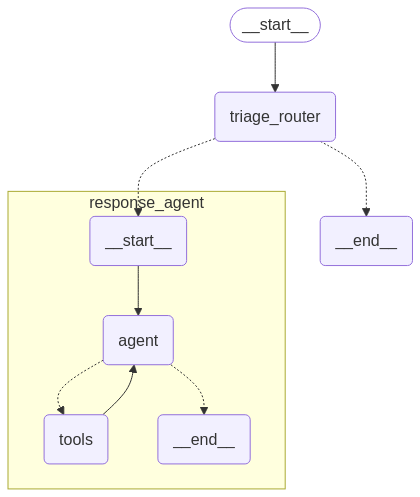

In [126]:
# Show the agent
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [127]:
email_input = {
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "email_thread": """Dear Valued Developer,

Don't miss out on this INCREDIBLE opportunity! 

🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite! 

✨ FEATURES:
- Revolutionary AI-powered code completion
- Cloud-based development environment
- 24/7 customer support
- And much more!

💰 Regular Price: $999/month
🎉 YOUR SPECIAL PRICE: Just $199/month!

🕒 Hurry! This offer expires in:
24 HOURS ONLY!

Click here to claim your discount: https://amazingdeals.com/special-offer

Best regards,
Marketing Team
---
To unsubscribe, click here
""",
}

In [129]:
response = email_agent.invoke({"email_input": email_input})

🚫 Classification: IGNORE - This email can be safely ignored


In [132]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [133]:
response = email_agent.invoke({"email_input": email_input})

📧 Classification: RESPOND - This email requires a response


In [134]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_t0mlOjJxIJvJxrGwktyGzigN)
 Call ID: call_t0mlOjJxIJvJxrGwktyGzigN
  Args:
    to: Alice Smith <alice.smith@company.com>
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thank you for bringing this to my attention. I will look into the missing endpoints for the new authentic